# Importing Libraries:

In [3]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout, Dense, Input, Embedding, LSTM, add, Reshape, concatenate
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
from textwrap import wrap
import re
import json

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [ ]:
# global constants
START_TOKEN = 'startseq'
END_TOKEN = 'endseq'
DENSENET_DIM = 1920

# Load data

In [5]:

# Open the captions_train2017.json file
with open('/kaggle/input/coco-2017-dataset/coco2017/annotations/captions_train2017.json', 'r') as f:
    data = json.load(f)
    data = data['annotations']
# Check the number of captions
num_captions = len(data)
print(f"Number of captions in captions_train2017: {num_captions}")

Number of captions in captions_train2017: 591753


In [6]:
img_cap_pairs = []

# Iterate over each annotation in the data
for sample in data:
#     img_name = '%012d.jpg' % sample['image_id']
    img_cap_pairs.append([sample['image_id'], sample['caption']])

# Create a DataFrame from the image-caption pairs
data = pd.DataFrame(img_cap_pairs, columns=['image', 'caption'])

# Reset the DataFrame index
data = data.reset_index(drop=True)

# Print the first few rows of the DataFrame
data.head()   

,image,caption
0,203564,A bicycle replica with a clock as the front wh...
1,322141,A room with blue walls and a white sink and door.
2,16977,A car that seems to be parked illegally behind...
3,106140,A large passenger airplane flying through the ...
4,106140,There is a GOL plane taking off in a partly cl...


## Visualization 

In [ ]:
def readImage(path, img_size=224):
    # Construct the full image path by joining the base directory path with the image filename
    img_path = os.path.join('/kaggle/input/coco-2017-dataset/coco2017/train2017', os.path.basename(path))
    
    # Load the image, convert it to an array, and normalize the pixel values
    img = load_img(img_path, color_mode='rgb', target_size=(img_size, img_size))
    img = img_to_array(img)
    img = img / 255.0

    return img

def display_images(temp_df):
    # Reset the index of the DataFrame
    temp_df = temp_df.reset_index(drop=True)
    
    # Create a figure with a specified size
    plt.figure(figsize=(20, 20))
    
    n = 0
    for i in range(15):
        n += 1
        
        # Create a subplot and adjust the spacing between subplots
        plt.subplot(5, 5, n)
        plt.subplots_adjust(hspace=0.7, wspace=0.3)
        
        # Load and display the image
        image = readImage(f"/kaggle/input/coco-2017-dataset/coco2017/train2017/{temp_df.image[i]}")
        plt.imshow(image)
        
        # Wrap the caption text to a maximum of 20 characters per line and set it as the title of the subplot
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        
        # Turn off the axis
        plt.axis("off")

# Call the display_images() function with a sample of 15 rows from the 'captions' DataFrame
display_images(data.sample(15))

# Data PREPROCESSING

## Text Preprocessing

In [13]:
def text_preprocessing(data):
    # Convert captions to lowercase
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    
    # Remove non-alphabetic characters
    data['caption'] = data['caption'].apply(lambda x: re.sub("[^A-Za-z]", " ", x))
    
    # Replace multiple whitespaces with a single whitespace
    data['caption'] = data['caption'].apply(lambda x: re.sub("\s+", " ", x))
    
    # Remove words with length less than or equal to 1
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word) > 1]))
    
    # Add start and end tokens to captions
    data['caption'] = f'{START_TOKEN} {data['caption']} {END_TOKEN}'
    
    return data

In [14]:
data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:10]

['startseq bicycle replica with clock as the front wheel endseq',
 'startseq room with blue walls and white sink and door endseq',
 'startseq car that seems to be parked illegally behind legally parked car endseq',
 'startseq large passenger airplane flying through the air endseq',
 'startseq there is gol plane taking off in partly cloudy sky endseq',
 'startseq blue and white color scheme in small bathroom endseq',
 'startseq this is blue and white bathroom with wall sink and lifesaver on the wall endseq',
 'startseq blue boat themed bathroom with life preserver on the wall endseq',
 'startseq the bike has clock as tire endseq',
 'startseq two cars parked on the sidewalk on the street endseq']

## Tokenization and Encoded Representation 
* The words in a sentence are separated/tokenized and encoded in a one hot representation
* These encodings are then passed to the embeddings layer to generate word embeddings

In [ ]:
# Create a tokenizer and fit it on the captions
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)

# Determine the vocabulary size
vocab_size = len(tokenizer.word_index) + 1

# Find the maximum caption length
max_length = max(len(caption.split()) for caption in captions)

# Get the unique image names
images = data['image'].unique().tolist()
nimages = len(images)

# Split the images into train and test sets
split_index = round(0.85 * nimages)
train_images = images[:split_index]
test_images = images[split_index:]

# Create train and test dataframes
train = data[data['image'].isin(train_images)].reset_index(drop=True)
test = data[data['image'].isin(test_images)].reset_index(drop=True)

# Convert a caption to a sequence of integers using the tokenizer
sample_caption = captions[1]
sequence = tokenizer.texts_to_sequences([sample_caption])[0]

## Image Feature Extraction
* DenseNet 201 Architecture was used to extract the features from the images
* Load pre-trained features from the images using DenseNet201 model

In [15]:
with open('/kaggle/input/features/features.json', 'r') as f:
    features = {k: np.array(v) for k, v in json.load(f).items()}

# Data Generation 
* Since Image Caption model training like any other neural network training is a highly resource utillizing process we cannot load the data into the main memory all at once, and hence we need to generate the data in the required format batch wise
* The inputs will be the image embeddings and their corresonding caption text embeddings for the training process
* The text embeddings are passed word by word for the caption generation during inference time

In [42]:
class CustomDataGenerator(Sequence):
    
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, 
                 vocab_size, max_length, features, shuffle=True):
    
        self.df = df.copy()  # Create a copy of the dataframe
        self.X_col = X_col  # Column name for image filenames
        self.y_col = y_col  # Column name for captions
        self.directory = directory  # Directory where images are located
        self.batch_size = batch_size  # Batch size
        self.tokenizer = tokenizer  # Tokenizer object
        self.vocab_size = vocab_size  # Vocabulary size
        self.max_length = max_length  # Maximum caption length
        self.features = features  # Dictionary of image features
        self.shuffle = shuffle  # Shuffle flag
        self.n = len(self.df)  # Number of samples in the dataframe
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)  # Shuffle the dataframe
    
    def __len__(self):
        return self.n // self.batch_size  # Compute the number of batches
    
    def __getitem__(self, index):
    
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size, :]
        X1, X2, y = self.__get_data(batch)  # Get data for the current batch      
        return (X1, X2), y
    
    def __get_data(self, batch):
        
        X1, X2, y = list(), list(), list()
        
        images = batch[self.X_col].tolist()
           
        for image in images:
            feature = self.features[str(image)]
            feature = np.reshape(feature, (DENSENET_DIM,))  # Reshape image feature
            
            captions = batch.loc[batch[self.X_col] == image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
        return X1, X2, y

# Modelling

In [16]:
class TransformerEncoderLayer(tf.keras.layers.Layer):

    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.layer_norm_1 = tf.keras.layers.LayerNormalization()
        self.layer_norm_2 = tf.keras.layers.LayerNormalization()
        self.attention = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense = tf.keras.layers.Dense(embed_dim, activation="relu")
    

    def call(self, x, training):
        x = self.layer_norm_1(x)
        x = self.dense(x)

        attn_output = self.attention(
            query=x,
            value=x,
            key=x,
            attention_mask=None,
            training=training
        )

        x = self.layer_norm_2(x + attn_output)
        return x

In [18]:
input1 = Input(shape=(DENSENET_DIM,))
input2 = Input(shape=(max_length,))
encoder = TransformerEncoderLayer(256, 8)

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)
img_features_reshaped = encoder(img_features_reshaped)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

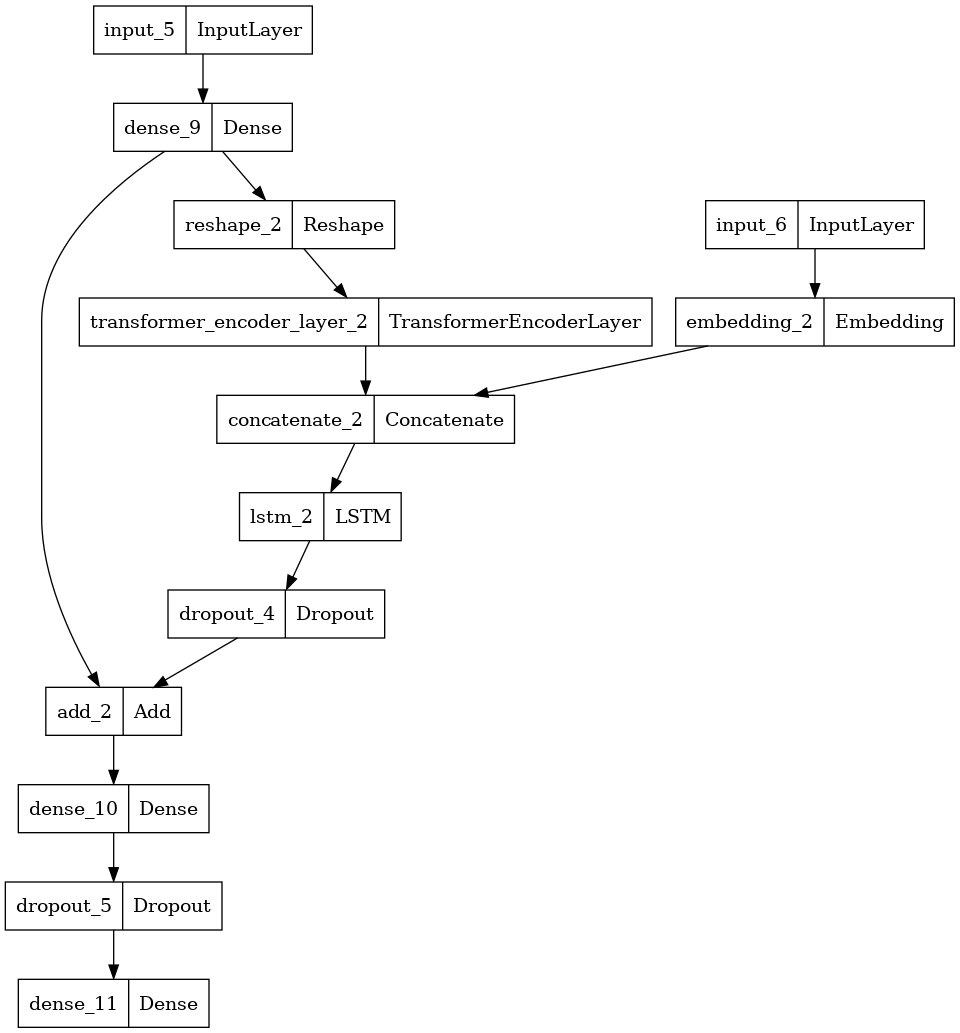

In [51]:
plot_model(caption_model)

In [53]:
# Create a custom data generator for training data
train_generator = CustomDataGenerator(df=train, X_col='image', y_col='caption', batch_size=64, directory='image_path',
                                      tokenizer=tokenizer, vocab_size=vocab_size, max_length=max_length, features=features)

# Create a custom data generator for validation data
validation_generator = CustomDataGenerator(df=test, X_col='image', y_col='caption', batch_size=64, directory='image_path',
                                      tokenizer=tokenizer, vocab_size=vocab_size, max_length=max_length, features=features)

In [54]:
model_name = "model.h5"

# Model checkpoint to save the best model based on validation loss
checkpoint = ModelCheckpoint(model_name, monitor="val_loss", mode="min", save_best_only=True, verbose=1)

# Early stopping to stop training if validation loss does not improve after certain epochs
earlystopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, restore_best_weights=True)

# Learning rate reduction to reduce learning rate if validation loss plateaus
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.2, min_lr=0.00000001)

In [55]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)

## Model Training

In [ ]:
history = caption_model.fit(
    train_generator,  # Training data generator
    epochs=50,  # Number of epochs for training
    validation_data=validation_generator,  # Validation data generator
    callbacks=[checkpoint, earlystopping, learning_rate_reduction]  # List of callback functions
)

Epoch 1/50
7859/7859 [==============================] - ETA: 0s - loss: 4.0832 - accuracy: 0.2873
Epoch 1: val_loss improved from inf to 3.54918, saving model to model.h5
7859/7859 [==============================] - 2990s 380ms/step - loss: 4.0832 - accuracy: 0.2873 - val_loss: 3.5492 - val_accuracy: 0.3344 - lr: 0.0010
Epoch 2/50
5780/7859 [=====================>........] - ETA: 9:20 - loss: 3.6069 - accuracy: 0.3317

In [ ]:
caption_model.save_weights('model.h5')
caption_model.save('model.keras')

In [19]:
caption_model.load_weights('model.h5')

## Accuracy plots

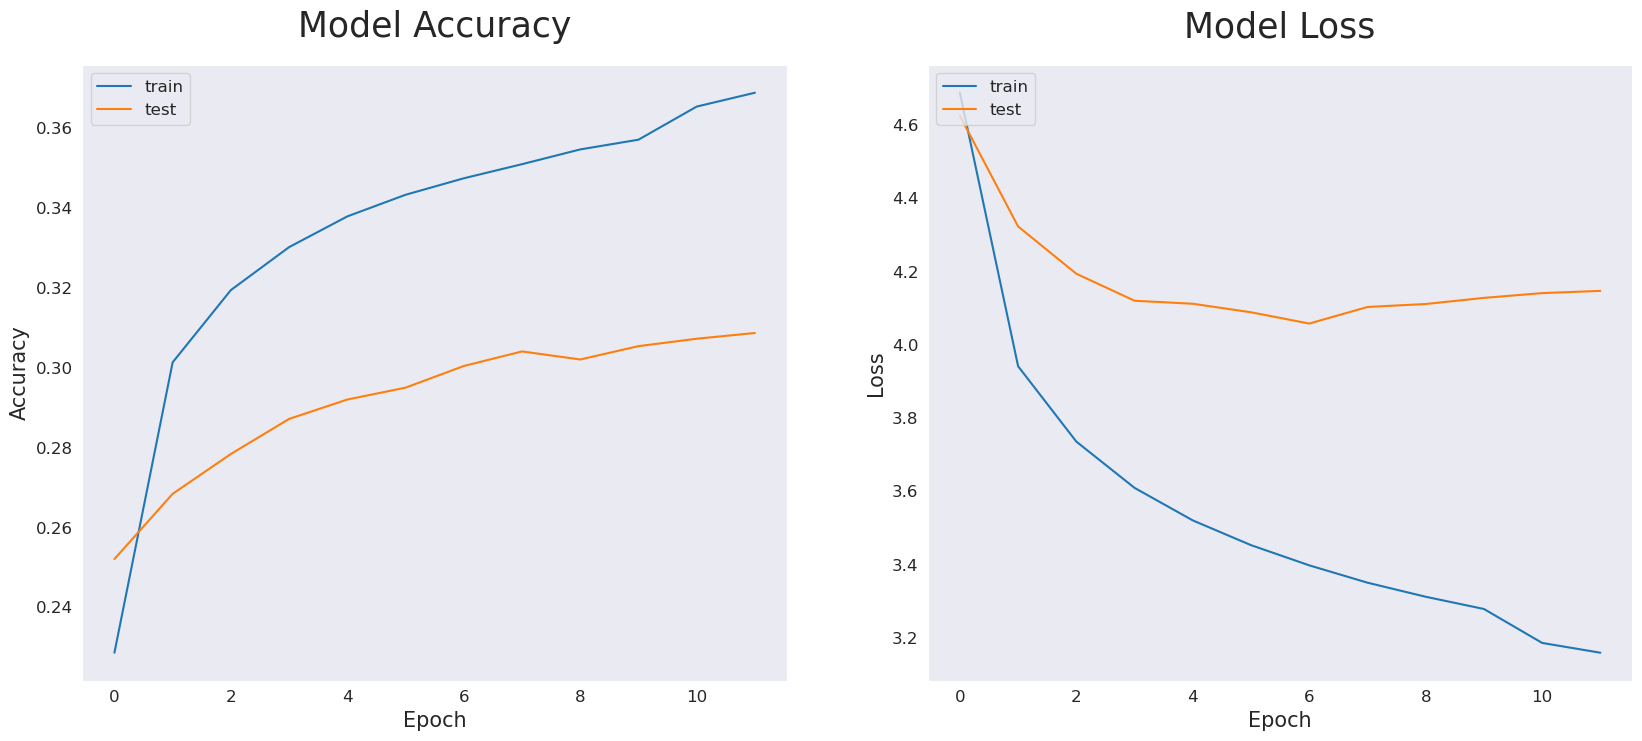

In [62]:
import matplotlib.pyplot as plt

plt.figure(figsize=[20, 8])

# Summarize history for accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy', size=25, pad=20)
plt.ylabel('Accuracy', size=15)
plt.xlabel('Epoch', size=15)
plt.legend(['train', 'test'], loc='upper left')

# Summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss', size=25, pad=20)
plt.ylabel('Loss', size=15)
plt.xlabel('Epoch', size=15)
plt.legend(['train', 'test'], loc='upper left')

plt.show()

# Caption Generation

In [24]:
def idx_to_word(integer,tokenizer):
    
    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [23]:
def predict_caption(fe, model, image, tokenizer, max_length):
    
#     feature = features[image]
    # Load and preprocess the image using load_img and img_to_array functions
    img = load_img(image, target_size=(224, 224))
    img = img_to_array(img)
    
    # Normalize the image pixel values to the range of [0, 1]
    img = img / 255.0
    
    # Expand the dimensions of the image array to match the model's input shape
    img = np.expand_dims(img, axis=0)
    
    # Extract the features by passing the preprocessed image through the feature extraction model (fe) using the predict method
    feature = fe.predict(img, verbose=0)
    in_text = START_TOKEN
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([feature,sequence], verbose=0)
        y_pred = np.argmax(y_pred)
        
        word = idx_to_word(y_pred, tokenizer)
        
        if word is None:
            break
            
        in_text+= " " + word
        
        if word == END_TOKEN:
            break
            
    return in_text[8:-7] 

## Random Samples for Caption Prediction 

In [34]:
samples = test.sample(15)
samples.reset_index(drop=True,inplace=True)

In [35]:
samples.head()

,image,caption
0,/kaggle/input/coco-2017-dataset/coco2017/train...,startseq very attractive woman playing video g...
1,/kaggle/input/coco-2017-dataset/coco2017/train...,startseq green plate with taco and bowl of chi...
2,/kaggle/input/coco-2017-dataset/coco2017/train...,startseq socializing family is playing game in...
3,/kaggle/input/coco-2017-dataset/coco2017/train...,startseq laptop computer sitting on desk with ...
4,/kaggle/input/coco-2017-dataset/coco2017/train...,startseq black vase full of yellow wilted sunf...


In [50]:
# Create a DenseNet201 model
model = DenseNet201()

# Create a feature extraction model by taking the output from the second last layer of the DenseNet201 model
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

for index,record in samples.iterrows():

    img = load_img(os.path.join(image_path,record['image']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.
    
    caption = predict_caption(fe, caption_model, record['image'], tokenizer, max_length)
    samples.loc[index,'caption'] = caption

1/1 [==============================] - 0s 26ms/step


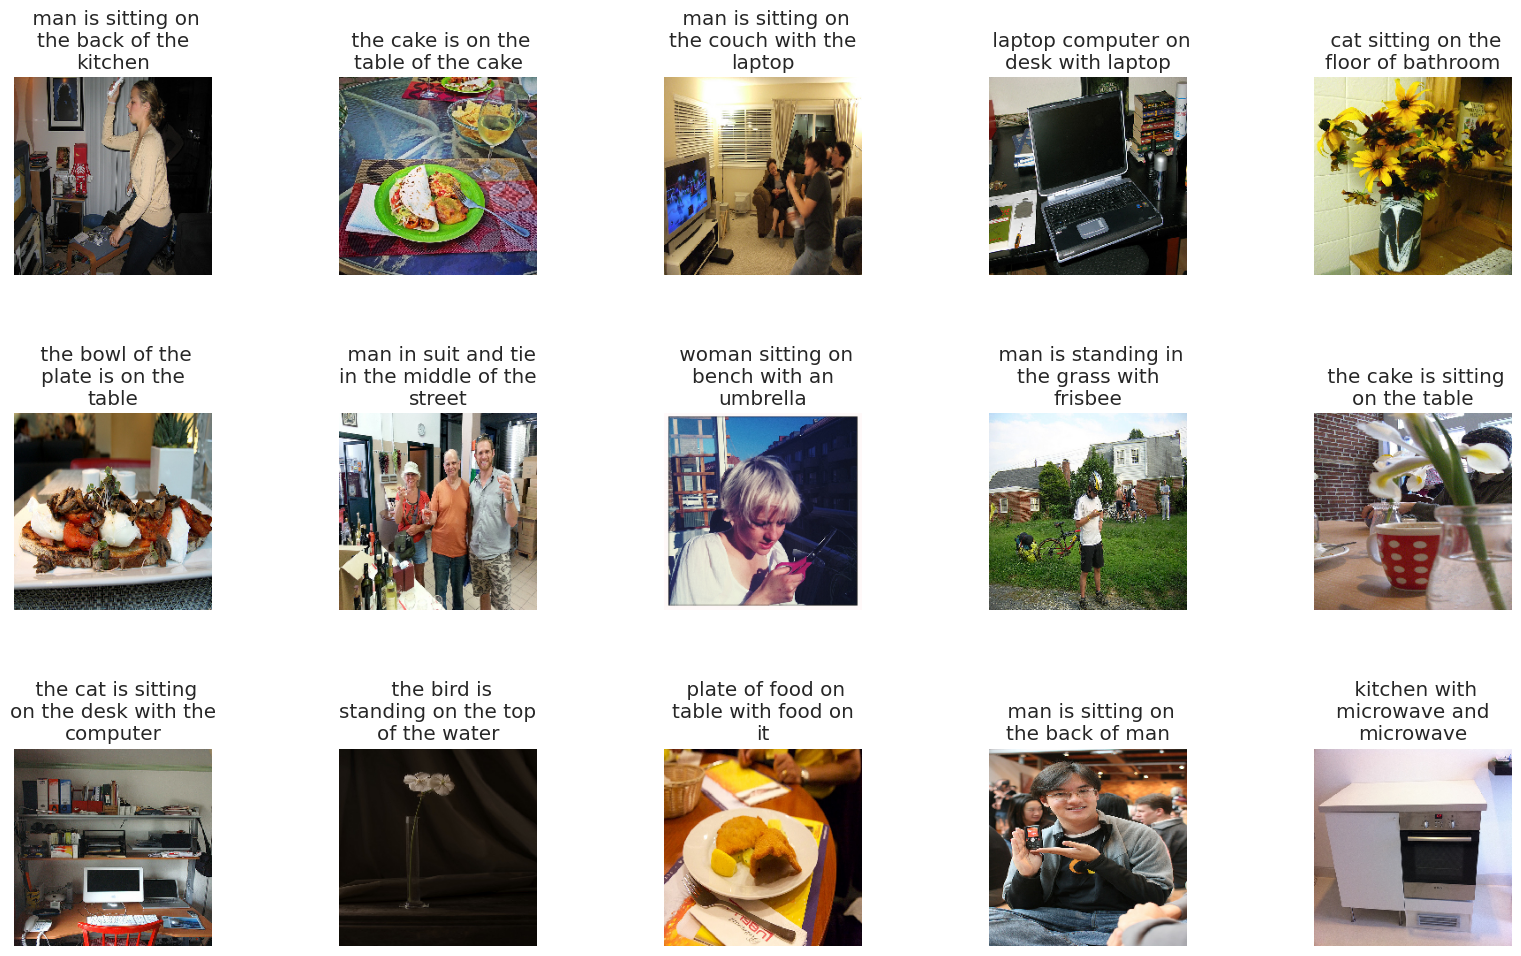

In [51]:
display_images(samples)

# Evaluation

In [25]:
# load a list of val
with open('/kaggle/input/coco-2017-dataset/coco2017/annotations/captions_val2017.json', 'r') as f:
    val = json.load(f)
    val = val['annotations']
# # Create a DataFrame from the image-caption pairs
df = pd.DataFrame([i['image_id'] for i in val], columns=['image_id'])
val = df.drop_duplicates(subset=['image_id'])

In [ ]:
# generate captions
# Create a DenseNet201 model
model = DenseNet201()

# Create a feature extraction model by taking the output from the second last layer of the DenseNet201 model
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

# generate captions
for index,record in tqdm(val.iterrows()):
    img_name = '%012d.jpg' % record['image_id']
    img_path = os.path.join('/kaggle/input/coco-2017-dataset/coco2017/val2017',img_name)
    caption = predict_caption(fe, caption_model, img_path, tokenizer, max_length)
    val.loc[index,'caption'] = caption

# save as a json
json_data = val.to_dict(orient='records')
with open('results.json', 'w') as json_file:
    json.dump(json_data, json_file)

1174it [16:20,  1.35it/s]